# Experiments on information loss 

## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
import collections
import math
sys.path.insert(0, '../rsemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


# Set a collection place for experiments

In [2]:
# do not rerun this cell
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [3]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')

In [4]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [5]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [6]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen]
print("The file you chose is:", file_chosen)

The file you chose is: ../not_pushed\topspin_data_anonymized\M002\008\EMG_recording.Poly5


In [7]:
# get the poly5 reading
data_emg = Poly5Reader(file_chosen)
data_samples = data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds = []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)

Reading file  ../not_pushed\topspin_data_anonymized\M002\008\EMG_recording.Poly5
	 Number of samples:  719840 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


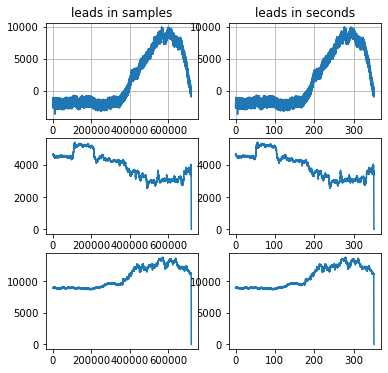

In [8]:
%matplotlib inline
# set up plot
x = data_samples
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0, 0].grid(True)
axis[0, 0].plot(x[0])
axis[0, 0].set(title='leads in samples')
axis[1, 0].plot(x[1])
axis[2, 0].plot(x[2])
axis[0, 1].set(title='leads in seconds')
axis[0, 1].grid(True)
axis[0, 1].plot(converted_to_seconds, x[0])
axis[1, 1].plot(converted_to_seconds, x[1])
axis[2, 1].plot(converted_to_seconds, x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [9]:
y_axis = widgets.Dropdown(
    options=["Samples", "Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)

Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [34]:
time_view = y_axis.value
time_view

'Seconds'

In [36]:
# type in start number and press return for it to update
start = input()

330


In [37]:
# type in end number and press return for it to update
end = input()

350


In [30]:
start_s = float(start)* emg_sample_rate
end_s = float(end)*emg_sample_rate

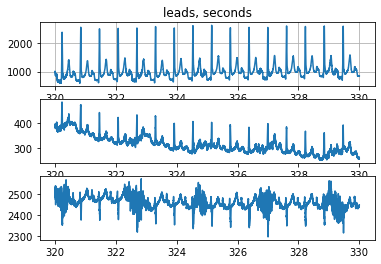

In [38]:
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])

if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples
    y = converted_to_seconds
    fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start_s):int(end_s)], x[0][int(start_s):int(end_s)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start_s):int(end_s)], x[1][int(start_s):int(end_s)])
    ax_3.plot(y[int(start_s):int(end_s)], x[2][int(start_s):int(end_s)])

Happy with your selection? If not redo, then we can see how the filter works on it.

In [36]:
%matplotlib inline
# generate x values
x = data_samples 


def my_butter_filter(x, low, high, freq):
    """
    Return band-pass butter filtered
    """
    x = hf.emg_bandpass_butter_sample(x, low, high, 2048, output='sos')
    components = hf.compute_ICA_two_comp(x)
    x = hf.pick_more_peaks_array(components)

    return x

In [37]:
if time_view == 'Samples':
    #
    int_slider1 = widgets.IntSlider(
        min=1, max=15, step=1,
        description='low end cutoff'
    )
    int_slider2 = widgets.IntSlider(
        value=500,
        min=1, max=1000, step=1,
        description='high end cutoff'
    )
    widgets.VBox(
        [

            int_slider1,
            int_slider2,

        ]
    )

    @widgets.interact(low=int_slider1, high=int_slider2)
    def update(low=int_slider1, high=int_slider2):
        with plt.style.context("ggplot"):
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.grid(True)
            [l.remove() for l in ax.lines]
            ax.plot(my_butter_filter(
                x[:, int(start):int(end)], low, high, 2048), color='C0')

else:
    int_slider1 = widgets.IntSlider(
        min=1, max=15, step=1,
        description='low end cutoff'
    )
    int_slider2 = widgets.IntSlider(
        value=500,
        min=1, max=1000, step=1,
        description='high end cutoff'
    )
    widgets.VBox(
        [

            int_slider1,
            int_slider2,

        ]
    )

    @widgets.interact(low=int_slider1, high=int_slider2)
    def update(low=int_slider1, high=int_slider2):
        with plt.style.context("ggplot"):
            fig, ax = plt.subplots(figsize=(6, 4))
            ax.grid(True)
            [l.remove() for l in ax.lines]
            ax.plot(y[int(start_s):int(end_s)], my_butter_filter(
                x[:, int(start_s):int(end_s)], low, high, 2048), color='C0')

interactive(children=(IntSlider(value=1, description='low end cutoff', max=15, min=1), IntSlider(value=500, de…

Once you are happy leave it. The values are then stored once you run the cellbelow:

In [38]:
high_end_cut = int_slider2.value
low_end_cut = int_slider1.value

# Visual examination
We can look at the product with 


In [39]:
lead_2 = data_samples[2]
components = hf.compute_ICA_two_comp(x)
x_singled_emg = hf.pick_more_peaks_array(components)

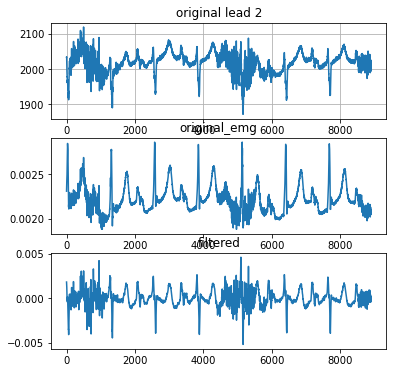

In [40]:
newly_filtered = my_butter_filter(x, low_end_cut, high_end_cut, 2048)
if time_view == 'Samples':
    fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 6))
    ax_1.plot(lead_2[int(start):int(end)])
    ax_1.set(title='original lead 2')
    ax_1.grid(True)
    ax_2.plot(x_singled_emg[int(start):int(end)])
    ax_2.set(title='original_emg')
    ax_3.plot(newly_filtered[int(start):int(end)])
    ax_3.set(title='filtered')

else:
    fig, (ax_1, ax_2, ax_3) = plt.subplots(nrows=3, figsize=(6, 6))
    ax_1.plot(y[int(start_s):int(end_s)], lead_2[int(start_s):int(end_s)])
    ax_1.set(title='original lead 2')
    ax_1.grid(True)
    ax_2.plot(y[int(start_s):int(end_s)],
              x_singled_emg[int(start_s):int(end_s)])
    ax_2.set(title='original_emg')
    ax_3.plot(y[int(start_s):int(end_s)],
              newly_filtered[int(start_s):int(end_s)])
    ax_3.set(title='filtered')

Looks like an improvement, but how much information did we lose?

# Looking at information loss

Here we will use power spectrum loss to understand information loss. If we get a tiny small negative number (less than 1/100) we will understand it as essentially zero (or somehow plus a very small noise?)

## Loss from lead_2 to ICA product

In [41]:
if time_view == 'Samples':
    split_loss = hf.compute_power_loss(lead_2[int(start):int(
        end)], 2048, x_singled_emg[int(start):int(end)], 2048)
else:
    split_loss = hf.compute_power_loss(lead_2[int(start_s):int(
        end_s)], 2048, x_singled_emg[int(start_s):int(end_s)], 2048)
split_loss

0.11894095995033105

## Loss from lead_2 to final filtering product

In [42]:
if time_view == 'Samples':
    final_loss = hf.compute_power_loss(lead_2[int(start):int(
        end)], 2048, newly_filtered[int(start):int(end)], 2048)
else:
    final_loss = hf.compute_power_loss(lead_2[int(start_s):int(
        end_s)], 2048, newly_filtered[int(start_s):int(end_s)], 2048)
final_loss

0.11894095977279528

I would argue when we lose we we lost more noise than important 'information', but now we have a framework to start comparing information loss

Now let's save the information we just generated.

In [43]:
data_now = [file_chosen, number_chosen, start, end, high_end_cut, low_end_cut, split_loss, final_loss, time_view]

In [44]:
data_now

['../not_pushed\\topspin_data_anonymized\\M001\\007\\EMG_recording.Poly5',
 6,
 '90',
 '9000',
 204,
 3,
 0.11894095995033105,
 0.11894095977279528,
 'Samples']

In [45]:
# run every time you want to append a new sample
big_data_list.append(data_now)

big_data_list

[['../not_pushed\\topspin_data_anonymized\\M001\\007\\EMG_recording.Poly5',
  6,
  '90',
  '9000',
  204,
  3,
  0.11894095995033105,
  0.11894095977279528,
  'Samples']]

In [46]:
columns_now = ['file_chosen', 
               'number_file', 
               'start_checked',
               'end_checked', 
               'high_end_filter',
               'low_end_filter', 
               'info_lost_split',
               'info_lost_final',
               'time_view'
              ]

df = pd.DataFrame(big_data_list, columns= columns_now)

In [47]:
df

,file_chosen,number_file,start_checked,end_checked,high_end_filter,low_end_filter,info_lost_split,info_lost_final,time_view
0,../not_pushed\topspin_data_anonymized\M001\007...,6,90,9000,204,3,0.118941,0.118941,Samples


In [48]:
df.to_csv('my_saved_experiments.csv')

You probably want to change the name to a timestamp, and save every hour, at least. 